In [1]:
# http://localhost:8187/notebooks/tsainbur/Projects/github_repos/umap_tensorflow/Notebooks/semisupervised-learning/cifar10-CNN13-baseline-convnet-keras-semi-with-fc-layers.ipynb

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [5]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 'full' # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_1.0_1024_full____2020_08_09_14_21_37_051212_baseline


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [8]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

- https://medium.com/fenwicks/tutorial-2-94-accuracy-on-cifar10-in-2-minutes-7b5aaecd9cdd
- https://colab.research.google.com/github/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb#scrollTo=n___bs94Rvm2
- https://www.tensorflow.org/tutorials/images/data_augmentation#using_tfimage
- https://github.com/tensorflow/models/pull/5906/files

In [9]:
import tensorflow_addons as tfa

In [10]:
def augment(image, label):
    image = tf.squeeze(image) # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, dims[0] + 6, dims[1] + 6) # crop 6 pixels
    image = tf.image.random_crop(image, size=dims)
    image = tf.image.random_brightness(image, max_delta=0.25)  # Random brightness
    image= tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.flip_left_right(image)
    image = tf.image.random_hue(image, 0.1, seed=None)
    image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
    image = tfa.image.rotate(image, tf.squeeze(tf.random.uniform(shape = (1,1), minval=-.4, maxval=.4)), interpolation='BILINEAR')
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (12,12), constant_values=0.5)[0]
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# new
def augment(image, label):
    image = tf.squeeze(image) # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, dims[0] + 6, dims[1] + 6) # crop 6 pixels
    image = tf.image.random_crop(image, size=dims)
    image = tf.image.random_brightness(image, max_delta=0.25)  # Random brightness
    image= tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.flip_left_right(image)
    image = tf.image.random_hue(image, 0.1, seed=None)
    image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
    image = tfa.image.rotate(image, tf.squeeze(tf.random.uniform(shape = (1,1), minval=-.4, maxval=.4)), interpolation='BILINEAR')
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (12,12), constant_values=0.5)[0]
    image = tf.clip_by_value(image, 0, 1)
    return image, label

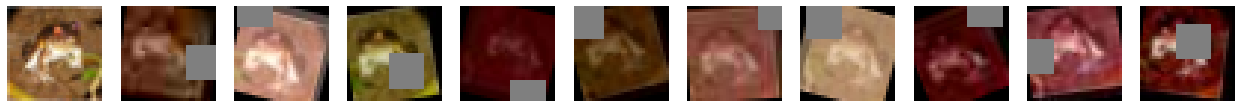

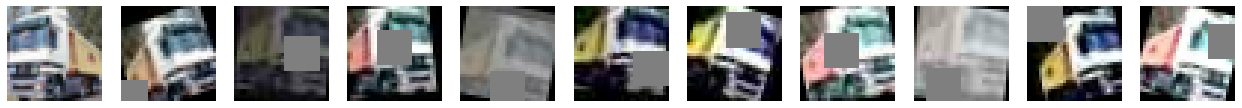

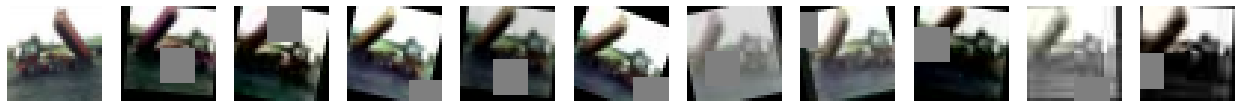

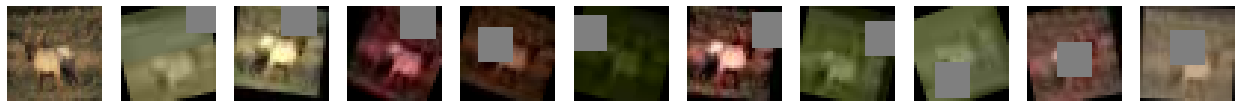

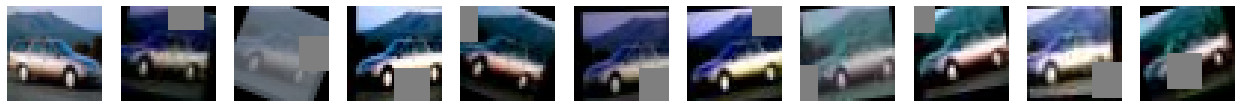

In [11]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(X_train[i])
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        ax.imshow(augment(X_train[i], Y_train[i])[0])
        ax.axis('off')

In [12]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled))
    .shuffle(1000)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

In [13]:
train_ds

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.uint8)>

In [14]:
for i in tqdm(iter(train_ds)):
    continue

### Build network

In [15]:
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )

In [16]:
from tensorflow.keras import datasets, layers, models

In [17]:
"""CNN13
See: 
https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
https://github.com/brain-research/realistic-ssl-evaluation

"""
lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [20]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(tf.keras.optimizers.Adam(1e-4), loss = loss, metrics=['accuracy'])

In [21]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [22]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [23]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .shuffle(1000)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

In [24]:
x1, y1 = next(iter(train_ds))

In [25]:
x1.shape, y1.shape

(TensorShape([512, 32, 32, 3]), TensorShape([512, 10]))

In [28]:
history = model.fit(
    train_ds,
    epochs=250,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/250
79/79 [==============================] - 25s 315ms/step - loss: 1.9635 - accuracy: 0.3699 - val_loss: 2.1176 - val_accuracy: 0.4075
Epoch 2/250
79/79 [==============================] - 25s 315ms/step - loss: 1.9050 - accuracy: 0.4014 - val_loss: 2.0570 - val_accuracy: 0.4454
Epoch 3/250
79/79 [==============================] - 25s 315ms/step - loss: 1.8775 - accuracy: 0.4175 - val_loss: 2.0087 - val_accuracy: 0.4938
Epoch 4/250
79/79 [==============================] - 25s 314ms/step - loss: 1.8581 - accuracy: 0.4287 - val_loss: 2.2252 - val_accuracy: 0.4217
Epoch 5/250
79/79 [==============================] - 25s 314ms/step - loss: 1.8308 - accuracy: 0.4473 - val_loss: 2.1714 - val_accuracy: 0.4602
Epoch 6/250
79/79 [==============================] - 16s 208ms/step - loss: 1.8166 - accuracy: 0.4579 - val_loss: 1.9926 - val_accuracy: 0.5088
Epoch 7/250
79/79 [==============================] - 21s 269ms/step - loss: 1.7985 - accuracy: 0.4672 - val_loss: 2.0568 - val_accuracy:

79/79 [==============================] - 25s 313ms/step - loss: 1.4680 - accuracy: 0.6666 - val_loss: 1.3998 - val_accuracy: 0.7318
Epoch 58/250
79/79 [==============================] - 21s 264ms/step - loss: 1.4595 - accuracy: 0.6712 - val_loss: 1.4232 - val_accuracy: 0.7200
Epoch 59/250
79/79 [==============================] - 16s 202ms/step - loss: 1.4605 - accuracy: 0.6717 - val_loss: 1.3358 - val_accuracy: 0.7624
Epoch 60/250
79/79 [==============================] - 25s 314ms/step - loss: 1.4569 - accuracy: 0.6748 - val_loss: 1.3764 - val_accuracy: 0.7414
Epoch 61/250
79/79 [==============================] - 25s 312ms/step - loss: 1.4511 - accuracy: 0.6806 - val_loss: 1.3798 - val_accuracy: 0.7448
Epoch 62/250
79/79 [==============================] - 24s 308ms/step - loss: 1.4497 - accuracy: 0.6791 - val_loss: 1.3832 - val_accuracy: 0.7375
Epoch 63/250
79/79 [==============================] - 25s 314ms/step - loss: 1.4471 - accuracy: 0.6799 - val_loss: 1.3784 - val_accuracy: 0.740

79/79 [==============================] - 22s 285ms/step - loss: 1.3439 - accuracy: 0.7381 - val_loss: 1.2393 - val_accuracy: 0.8145
Epoch 114/250
79/79 [==============================] - 14s 180ms/step - loss: 1.3417 - accuracy: 0.7390 - val_loss: 1.2581 - val_accuracy: 0.8019
Epoch 115/250
79/79 [==============================] - 24s 301ms/step - loss: 1.3430 - accuracy: 0.7403 - val_loss: 1.2337 - val_accuracy: 0.8186
Epoch 116/250
79/79 [==============================] - 25s 312ms/step - loss: 1.3396 - accuracy: 0.7428 - val_loss: 1.2634 - val_accuracy: 0.8014
Epoch 117/250
79/79 [==============================] - 25s 313ms/step - loss: 1.3355 - accuracy: 0.7441 - val_loss: 1.2551 - val_accuracy: 0.8066
Epoch 118/250
79/79 [==============================] - 25s 312ms/step - loss: 1.3365 - accuracy: 0.7434 - val_loss: 1.2447 - val_accuracy: 0.8092
Epoch 119/250
79/79 [==============================] - 25s 311ms/step - loss: 1.3322 - accuracy: 0.7456 - val_loss: 1.2427 - val_accuracy:

79/79 [==============================] - 25s 316ms/step - loss: 1.2782 - accuracy: 0.7768 - val_loss: 1.2022 - val_accuracy: 0.8345
Epoch 170/250
79/79 [==============================] - 25s 316ms/step - loss: 1.2735 - accuracy: 0.7789 - val_loss: 1.2216 - val_accuracy: 0.8189
Epoch 171/250
79/79 [==============================] - 25s 316ms/step - loss: 1.2732 - accuracy: 0.7792 - val_loss: 1.2171 - val_accuracy: 0.8241
Epoch 172/250
79/79 [==============================] - 15s 184ms/step - loss: 1.2716 - accuracy: 0.7791 - val_loss: 1.1943 - val_accuracy: 0.8333
Epoch 173/250
79/79 [==============================] - 20s 259ms/step - loss: 1.2702 - accuracy: 0.7814 - val_loss: 1.2128 - val_accuracy: 0.8252
Epoch 174/250
79/79 [==============================] - 19s 244ms/step - loss: 1.2684 - accuracy: 0.7806 - val_loss: 1.1881 - val_accuracy: 0.8381
Epoch 175/250
79/79 [==============================] - 16s 207ms/step - loss: 1.2684 - accuracy: 0.7809 - val_loss: 1.1896 - val_accuracy:

In [29]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)

In [30]:
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 4s 12ms/step - loss: 1.2306 - accuracy: 0.8152


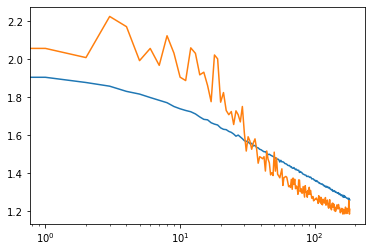

In [31]:
plt.semilogx(history.history['loss'])
plt.semilogx(history.history['val_loss'])

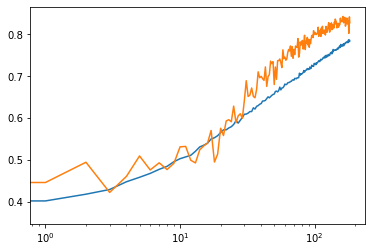

In [32]:
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])